## Analyze clusters among anomalies
The clustering approach can help to gain insight into the model by grouping the anomalous spectra into clusters based on their similarity in terms of the weights assigned by the LIME algorithm. This can help identify patterns or trends in the explanations that may not be immediately apparent from the weights alone.

For example, certain clusters might have higher explanation weights for certain wavelength ranges, or certain clusters have higher explanation weights overall. This can help to understand which features of the spectra are most important for the model's predictions, and can potentially uncover new scientific insights.

Additionally, by plotting the mean spectrum and mean explanation weights for each cluster, I can get a sense of how the model is using different features of the spectra to make its predictions, and identify any patterns or trends in the model's behavior that may be relevant to the anomaly detection task.

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from astroExplain.spectra.notebook import fig_axs_interpret_cluster
from anomaly.constants import GALAXY_LINES

2023-01-30 15:47:08.280425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-30 15:47:08.280446: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [2]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12"
iml_use_case_directory = (
    f"{user}/explain-me-why/sections/"
    "figures/iml_use_cases"
)

metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel100"
# metric = "mse_filter_250kms_noRel100"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/explanation/{model}/{metric}"
)

In [2]:
from typing import Tuple
from matplotlib.figure import Figure
from matplotlib.axes import Axes

def fig_axs_interpret_cluster(
    wave: np.array,
    mean_anomaly: np.array,
    median_anomaly: np.array,
    median_weights: np.array,
    mean_weights: np.array,
    fig_size=None
) -> Tuple[Figure, Axes]:
    """
    Plot the mean and median anomaly and the mean and median
    explanation weights.

    INPUT

    wave: wavelength array
    mean_anomaly: mean anomaly array
    median_anomaly: median anomaly array
    median_weights: median explanation weights array
    mean_weights: mean explanation weights array
    fig_size: figure size

    OUTPUT

    fig: figure
    axs: axes
    """

    fig, axs = plt.subplots(
        nrows=3, ncols=1,
        figsize=fig_size,
        sharex=True,
        sharey=False,
        tight_layout=True,
    )

    axs[0].plot(wave, median_anomaly, c="black", label="Median")
    axs[0].set_ylabel("Normalized flux", fontsize=8)

    axs[1].plot(wave, mean_anomaly, c="black", label="Mean")
    axs[1].set_ylabel("Normalized flux", fontsize=8)

    axs[2].plot(wave, median_weights, color="black", label="Median")
    axs[2].plot(wave, mean_weights, color="blue", label="Mean")

    axs[2].set_ylabel("Explanation weight", fontsize=8)
    axs[2].set_ylim(0, 1.01)

    return fig, axs

In [3]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")
anomalies = np.load(f"{data_directory}/top_anomalies.npy")
df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz", index_col="specobjid"
)

# load the weights
explanation_weights = np.load(
    f"{data_directory}/explanation_weights/weights_all_abs_"
    f"smooth_True_drop_0.05_{metric}_bin_03.npy"
)

In [4]:
explanation_weights.min(), explanation_weights.max()

(0.0, 1.0)

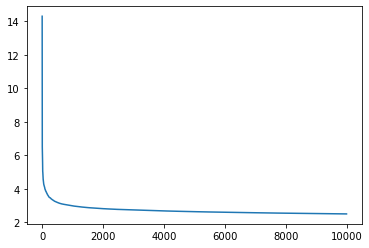

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
# reverse spectra in anomalies array as well
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

In [6]:
# # Create a list to store the evaluation metric values
# inertias = []
# n_clusters = range(2, 12)
# # Fit the k-means model with a range of values for the number of clusters
# for n in n_clusters:
#     kmeans = KMeans(n_clusters=n, random_state=0)
#     kmeans.fit(explanation_weights)
#     inertias.append(kmeans.inertia_)
#     print(f"n: {n}, inertia: {kmeans.inertia_}", end="\r")

In [7]:
# # Plot the evaluation metric values against the number of clusters
# fig, ax = plt.subplots(figsize=None)

# inertias = np.array(inertias)
# inertias = inertias / inertias.max()
# ax.plot(n_clusters, inertias, '-o')
# ax.set_xlabel('Number of clusters')
# ax.set_ylabel('Inertia')

# save_to = f"{user}/explain-me-why/sections/figures/iml_use_cases/"
# fig.savefig(f"{save_to}/kmeans_inertias_{metric}.pdf")

In [8]:
# Use k-means clustering to group the spectra
kmeans = KMeans(n_clusters=7, random_state=0)
cluster_labels = kmeans.fit_predict(explanation_weights)

Cluster N 0: 1176
Cluster N 1: 1358
Cluster N 2: 2464
Cluster N 3: 1156
Cluster N 4: 1006
Cluster N 5: 1109
Cluster N 6: 1731


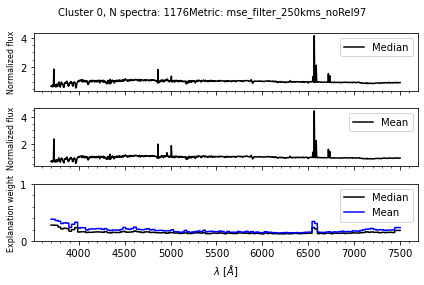

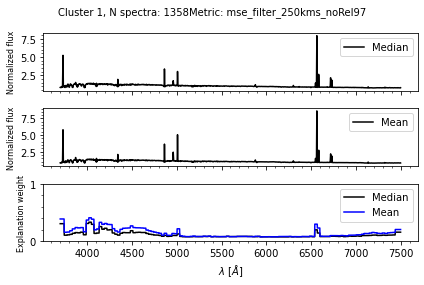

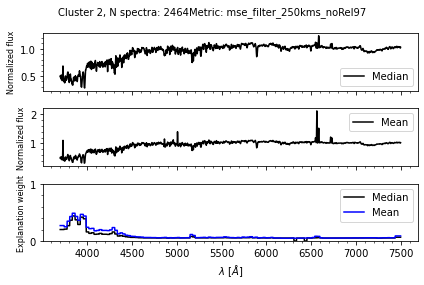

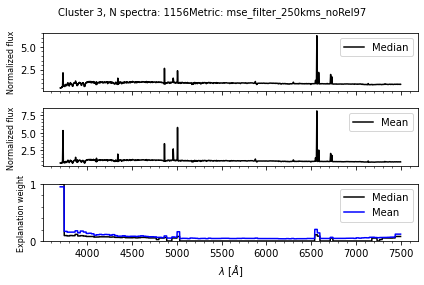

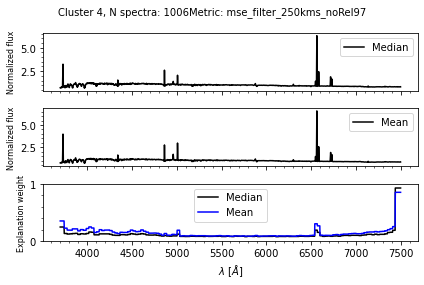

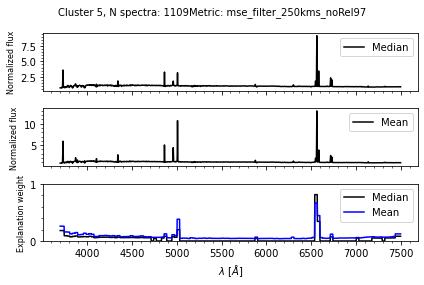

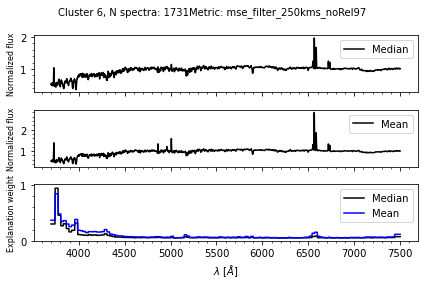

In [10]:
# plot mean and median of the anomalies and explanation weights
# per cluster
n_clusters = kmeans.n_clusters

for cluster_number in range(n_clusters):

    # Select the spectra in the cluster
    cluster_anomalies = anomalies[cluster_labels == cluster_number]

    n_spectra_in_cluster = len(cluster_anomalies)

    cluster_weights = explanation_weights[cluster_labels == cluster_number]
    cluster_mean_anomaly = np.mean(cluster_anomalies, axis=0)
    cluster_median_anomaly = np.median(cluster_anomalies, axis=0)

    # Compute summary statistics for the explanations in the cluster
    cluster_median_weights = np.median(cluster_weights, axis=0)
    cluster_mean_weights = np.mean(cluster_weights, axis=0)
    cluster_std_weights = np.std(cluster_weights, axis=0)



    fig, axs = fig_axs_interpret_cluster(
        wave,
        mean_anomaly=cluster_mean_anomaly,
        median_anomaly=cluster_median_anomaly,
        median_weights=cluster_median_weights,
        mean_weights=cluster_mean_weights,
        fig_size=None,
    )

    axs[2].set_xlabel("$\lambda$ [$\AA$]")


    for ax in axs:
        ax.legend()
        ax.minorticks_on()

    fig.suptitle(
        (
            f"Cluster {cluster_number}, "
            f"N spectra: {n_spectra_in_cluster}"
            f"Metric: {metric}"
        ),
        fontsize=10
    )

    print(
        f"Cluster N {cluster_number}: "
        f"{n_spectra_in_cluster}"
    )

    # create cluster directory if it does not exist
    cluster_directory = f"{iml_use_case_directory}/clustering"

    if not os.path.exists(cluster_directory):
        os.makedirs(cluster_directory)

    fig.savefig(
        f"{cluster_directory}/"
        f"cluster_{cluster_number}_metric_{metric}_bin_{bin_id}.pdf"
    )

In [ ]:
# from typing import Tuple
# from matplotlib.figure import Figure, Axes

# def fig_axs_interpret_cluster(
#     wave: np.array,
#     mean_anomaly: np.array,
#     median_anomaly: np.array,
#     median_weights: np.array,
#     mean_weights: np.array,
#     fig_size=None
# )-> Tuple[Figure, Axes]:

#     fig, axs = plt.subplots(
#         nrows=3, ncols=1,
#         figsize=fig_size,
#         sharex=True,
#         sharey=False,
#         tight_layout=True,
#     )

#     axs[0].plot(wave, median_anomaly, c="black", label="Median")
#     axs[0].set_ylabel("Normalized flux", fontsize=8)
    
#     axs[1].plot(wave, mean_anomaly, c="black", label="Mean")
#     axs[1].set_ylabel("Normalized flux", fontsize=8)

#     axs[2].plot(wave, median_weights, color="black", label="Median")
#     axs[2].plot(wave, mean_weights, color="blue", label="Mean")
    
#     axs[2].set_ylabel("Explanation weight", fontsize=8)
#     axs[2].set_ylim(0, 1.01)

#     axs[2].set_xlabel("$\lambda$ [$\AA$]")

#     return fig, axs


In [ ]:
# # Create a figure with a grid of subplots
# fig, axs = plt.subplots(
#     kmeans.n_clusters,
#     3,
#     tight_layout=True,
#     sharex=False,
#     sharey=False,
#     figsize=(20, 20),
# )

# # minor ticks on
# for ax in axs.flat:
#     ax.minorticks_on()

# # Add a title to the figure
# fig.suptitle(
#     f"Mean and standard deviation of the weights for the top 10k anomalies, {metric}, {bin_id}",
#     fontsize=12,
# )

# # Loop over the clusters
# for i in range(kmeans.n_clusters):
#     # Select the spectra in the cluster
#     cluster_anomalies = anomalies[cluster_labels == i]
#     cluster_weights = explanation_weights[cluster_labels == i]

#     # Compute summary statistics for the explanations in the cluster
#     cluster_median_weights = np.median(cluster_weights, axis=0)
#     cluster_mean_weights = np.mean(cluster_weights, axis=0)
#     cluster_std_weights = np.std(cluster_weights, axis=0)

#     # Plot the mean and standard deviation for the cluster
#     axs[i, 0].plot(
#         wave,
#         cluster_median_weights,
#         linewidth=2,
#         label=f"median weights cluster {i}",
#     )

#     # axs[i, 0].fill_between(
#     #     wave,
#     #     cluster_median_weights - cluster_std_weights,
#     #     cluster_median_weights + cluster_std_weights,
#     #     alpha=0.2,
#     # )

#     axs[i, 0].legend()
#     axs[i, 0].set_ylabel("Explanation weights")

#     axs[i, 1].plot(
#         wave,
#         cluster_mean_weights,
#         linewidth=2,
#         label=f"mean weights cluster {i}",
#     )
#     axs[i, 1].legend()

#     # axs[i, 1].fill_between(
#     #     wave,
#     #     cluster_mean_weights - cluster_std_weights,
#     #     cluster_mean_weights + cluster_std_weights,
#     #     alpha=0.2,
#     # )

#     axs[i, 1].set_ylabel("explanation weights")

#     # plot the mean and median of the anomalies in the cluster

#     axs[i, 2].plot(
#         wave,
#         np.median(cluster_anomalies, axis=0),
#         linewidth=2,
#         label=f"median anomalies cluster {i}",
#     )

#     axs[i, 2].legend()

#     # axs[i, 2].fill_between(
#     #     wave, np.median(cluster_anomalies, axis=0) - np.std(cluster_anomalies, axis=0),
#     #     np.median(cluster_anomalies, axis=0) + np.std(cluster_anomalies, axis=0), alpha=0.2
#     # )

#     axs[i, 2].set_ylabel("Anomalies")

#     axs[i, 2].plot(
#         wave,
#         np.mean(cluster_anomalies, axis=0),
#         linewidth=2,
#         label=f"mean anomalies cluster {i}",
#     )

#     axs[i, 2].legend()

#     # axs[i, 2].fill_between(
#     #     wave, np.mean(cluster_anomalies, axis=0) - np.std(cluster_anomalies, axis=0),
#     #     np.mean(cluster_anomalies, axis=0) + np.std(cluster_anomalies, axis=0), alpha=0.2
#     # )

#     axs[i, 2].set_ylabel("Anomalies")

#     # Print the number of spectra in the cluster
#     print(f"Number of spectra in cluster {i}: {len(cluster_anomalies)}")

# # Label the x-axis and show the figure
# plt.xlabel("Wavelength (Å)")
# plt.show()

# # save figure to pdf in data directory

# # fig.savefig(f"{data_directory}/cluster_mean_std_weights_top_10k_anomalies.pdf")